# Calibración de Sonda para plasmas RF

El siguiente código busca calibrar la sonda Langmuir a partir de los datos medidos en el SCR-1. Se busca comparar los datos obtenidos, para determinar el modelo por el cual deberían ser procesados, siguiendo el paper publicado por Chen en el 2012.

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import scipy
from scipy import constants
from scipy import stats
from numpy.lib import scimath
import bottleneck as bn #media movil
import findiff as ff #derivadas
from scipy.stats import anderson

# PlasmaPy
import astropy.units as u
import os
from pprint import pprint
import plasmapy.diagnostics.langmuir
from plasmapy.diagnostics.langmuir import Characteristic, swept_probe_analysis

import warnings
warnings.filterwarnings("ignore")

In [2]:
file_dir = r'C:\Users\allan\Documents\Repositories\plasmatec\Sonda-de-Langmuir\Datos\sonda_simple_barrido.xlsx'
probe_diameter = 1e-3*u.m
probe_length = 3.5e-3*u.m
probe_area = (probe_diameter*probe_length*np.pi + np.pi*0.25*(probe_diameter)**2)

In [3]:
Mi = scipy.constants.physical_constants['proton mass'][0] #Masa del protón, ión H
me = scipy.constants.physical_constants['electron mass'][0] #Masa del electrón
e_c = scipy.constants.physical_constants['elementary charge'][0]
kb=scipy.constants.physical_constants["Boltzmann constant"][0]

In [4]:
def CargarDatosSonda(file_dir): 
    #Se importan los datos
    datos = np.array(pd.read_excel(file_dir)).T # se pasan a numpy y se transponen
    cont = len(datos[1])
    a = 0.00001
    for i in range(cont):
        if np.absolute(datos[1,i]) > a : #Deben filtrarse los datos mayores a 'a'
                V = datos[0,:i]
                I = datos[1,:i]
    I_movil = bn.move_mean(I, window=5, min_count=1) #bottleneck
    return V, I, I_movil

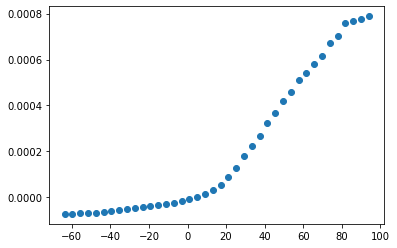

In [5]:
Voltaje,_,Corriente = CargarDatosSonda(file_dir)
plt.scatter(Voltaje,Corriente)
plt.show()

{'I_es': <Quantity 0.0003222 A>,
 'I_is': <Quantity -7.25e-05 A>,
 'T_e': <Quantity [14.3786184 , 14.38702128] eV>,
 'V_F': <Quantity 5.006863 V>,
 'V_P': <Quantity 41.436439 V>,
 'hot_fraction': 0.5000466941127463,
 'n_e': <Quantity 2.69024115e+14 1 / m3>,
 'n_i': <Quantity 1.72533254e+15 1 / m3>,
 'n_i_OML': <Quantity 1.13138958e+15 1 / m3>}


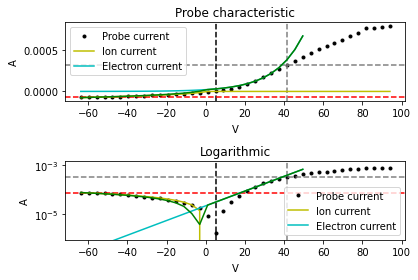

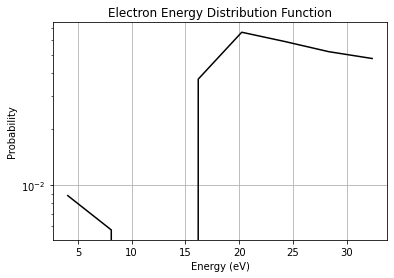

In [6]:
characteristic = Characteristic(u.Quantity(Voltaje,u.V),u.Quantity(Corriente,u.A))
pprint(swept_probe_analysis(characteristic,probe_area, 'H',bimaxwellian=True,visualize=True,plot_EEDF=True))
plt.show()

## Utilizando Langmuir Motley con correcciones de Chen para Plasmas RF

Este corresponde al análisis más 'común' para la curva $I$-$V$ de una sonda Langmuir, para la calibración, Chen propone hacer $4$ gráficas usando esta teoría: para la sección iónica $I^2$-$V$, para la sección electrónica $dI/dV$-$V$ y para toda la curva se grafica $\ln(I)$-$V$, esto permite ver el comportamiento de esta teoría una vez aplicada al plasma de la fuente RF. Entonces, utilizando los datos que se poseen, se realizarán las gráficas respectivas, para una toma de datos.

In [7]:
def PositivoNegativo(Corriente,Voltaje):
    Volt_pos=Voltaje[np.where(Voltaje>=0)]
    Volt_neg=Voltaje[np.where(Voltaje<0)]
    Corr_pos=Corriente[np.where(Voltaje>=0)]
    Corr_neg=Corriente[np.where(Voltaje<0)]
    return (Volt_pos,Corr_pos),(Volt_neg,Corr_neg)

In [8]:
Pos_Values,Neg_Values = PositivoNegativo(Corriente,Voltaje)

In [9]:
def DiferenciasFinitasSonda(Voltaje,Corriente):
    dV = Voltaje[1] - Voltaje[0] #definir el diferencial
    d_dV = ff.FinDiff(0, dV) #definir el operador y su orden
    #dI_dV = d_dV(I)
    dIdV = d_dV(Corriente)
    return dIdV

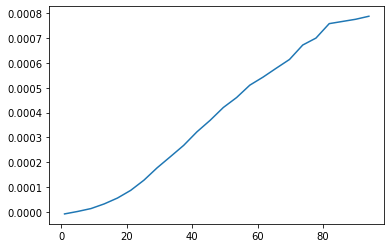

In [10]:
plt.plot(Pos_Values[0],Pos_Values[1])
plt.show()

In [11]:
dIdV = DiferenciasFinitasSonda(Pos_Values[0],Pos_Values[1])

In [12]:
Neg_Values[1].shape,Neg_Values[0].shape

((16,), (16,))

In [13]:
Pos_Values[0][np.where(dIdV==np.max(dIdV))],np.max(dIdV)

(array([41.436439]), 1.2476066950775118e-05)

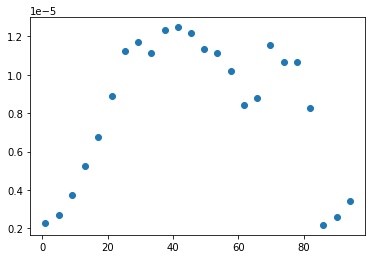

In [14]:
plt.scatter(Pos_Values[0],dIdV)
plt.show()

In [15]:
def SheathPlot(Voltaje,Corriente):
    Pos_Values,Neg_Values = PositivoNegativo(Corriente,Voltaje)
    
    fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize = (20, 10))
    
    ax1.scatter(Voltaje,Corriente)
    ax1.set_xlabel('Voltaje [V]')
    ax1.set_ylabel('Corriente [A]')
    
    ax3.scatter(Neg_Values[0],Neg_Values[1])
    result3 = scipy.stats.linregress(Neg_Values[0],Neg_Values[1])
    I_ion=Neg_Values[1].copy()
    Volt_Neg=Neg_Values[0].copy()
    count3=0
    while result3.rvalue**2<1:
        index = np.where(Volt_Neg == np.min(Volt_Neg))
        I_ion=np.delete(I_ion,index)
        Volt_Neg=np.delete(Volt_Neg,index)
        result3 = scipy.stats.linregress(Volt_Neg,I_ion)
        count3 = count3+1
        if count3>0.65*len(Neg_Values[0]):
            break
    fitIonC = result3.slope*Neg_Values[0]+result3.intercept
    ax3.plot(Neg_Values[0],fitIonC)
    ax3.set_xlabel('Voltaje [V]')
    ax3.set_ylabel('Corriente [A]')
    
    dIdV = DiferenciasFinitasSonda(Pos_Values[0],Pos_Values[1]-result3.intercept)
    lnI = np.log(Pos_Values[1][np.where(Pos_Values[1]>0)]-result3.intercept)
    ax2.plot(Pos_Values[0],dIdV)
    ax2.set_xlabel('Voltaje [V]')
    ax2.set_ylabel('dI/dV [Ohm^-1]')
    result4 = scipy.stats.linregress(Pos_Values[0][np.where(Pos_Values[1]>0)],lnI)
    Volt_Pos = Pos_Values[0][np.where(Pos_Values[1]>0)]
    ax4.set_xlabel('Voltaje [V]')
    ax4.set_ylabel('ln(Corriente)')
    count4 = 0
    while result4.rvalue**2<1:
        index = np.where(lnI == np.max(lnI))
        Volt_Pos=np.delete(Volt_Pos,index)
        lnI=np.delete(lnI,index)
        result4 = scipy.stats.linregress(Volt_Pos,lnI)
        count4 = count4+1
        if count4>0.65*len(Pos_Values[0])or Volt_Pos[-1]<=Pos_Values[0][np.where(dIdV==np.max(dIdV))]:
            break
    fitlnI = result4.slope*Volt_Pos+result4.intercept
    ax4.scatter(Volt_Pos,lnI)
    ax4.plot(Volt_Pos,fitlnI)
    plt.show()
    return (1/result4.slope*u.eV,2*result4.stderr/result4.slope**2*u.eV),result3.intercept

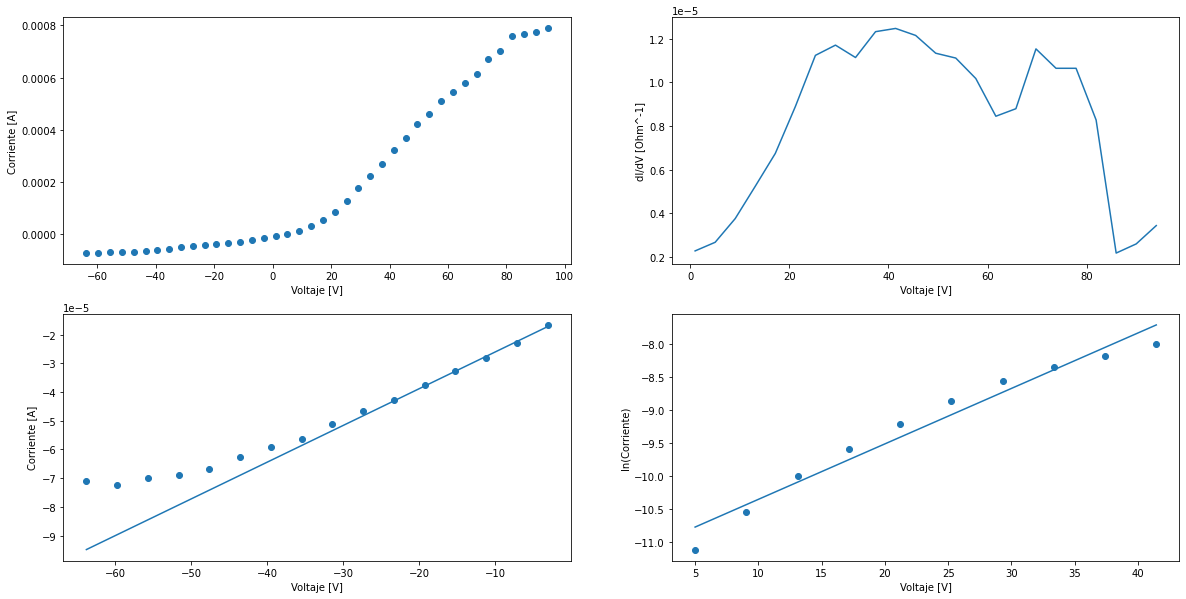

((<Quantity 11.87207025 eV>, <Quantity 1.6653775 eV>), -1.3247417442868076e-05)

In [16]:
temperatura,I_sat_ion = SheathPlot(Voltaje,Corriente)
temperatura,I_sat_ion

In [17]:
def CorrienteSaturaciónIónica(Corriente,Voltaje):
    Pos_Values,Neg_Values = PositivoNegativo(Corriente,Voltaje)
    
    result = scipy.stats.linregress(Neg_Values[0],Neg_Values[1])
    Volt_Neg = Neg_Values[0].copy()
    Curr_Neg = Neg_Values[1].copy()
    count = 0
    while result.rvalue**2<1:
        index = np.where(Volt_Neg == np.min(Volt_Neg))
        Volt_Neg=np.delete(Volt_Neg,index)
        Curr_Neg=np.delete(Curr_Neg,index)
        result = scipy.stats.linregress(Volt_Neg,Curr_Neg)
        count+=1
        if count>0.65*len(Neg_Values[0]):
            break
    corriente_i=result.intercept
    return (corriente_i*u.A,2*result.intercept_stderr*u.A)

In [18]:
corriente_i = CorrienteSaturaciónIónica(Corriente,Voltaje)
corriente_i

(<Quantity -1.32474174e-05 A>, <Quantity 1.17130189e-06 A>)

In [19]:
def SaturaciónElectrónica(Corriente,Voltaje):
    Pos_Values,Neg_Values = PositivoNegativo(Corriente,Voltaje)
    dIdV = DiferenciasFinitasSonda(Pos_Values[0],Pos_Values[1]-corriente_i[0].value)
    voltaje_s=Pos_Values[0][np.where(dIdV==np.max(dIdV))]
    corriente_e=Pos_Values[1][np.where(Pos_Values[0]==voltaje_s)]
    return (voltaje_s*u.V,0.000001/np.sqrt(12)*u.V), (corriente_e*u.A,0.000001*u.A/np.sqrt(12))

In [20]:
voltaje_s,corriente_e = SaturaciónElectrónica(Corriente,Voltaje)
voltaje_s,corriente_e

((<Quantity [41.436439] V>, <Quantity 2.88675135e-07 V>),
 (<Quantity [0.0003222] A>, <Quantity 2.88675135e-07 A>))

In [21]:
def DensidadElectrónica(temperatura,corriente_e):
    Rp = 0.5e-03*u.meter
    L = 3.5e-03*u.meter
    Ap = 2*np.pi*Rp*L + np.pi*Rp**2
    uAp = np.sqrt(((2*np.pi*Rp)*(0.1e-03*u.m))**2+((2*np.pi*Rp+2*np.pi*L)*(0.1e-03*u.m))**2)
    densidades_e = []
    ec = scipy.constants.physical_constants['elementary charge'][0]; #La carga elemental
    me = 9.10938291*10**(-31)
    
    ne = corriente_e[0].to(u.C/u.s)*(me*u.kg)**(1/2)/(ec*u.C*Ap*((temperatura[0].to(u.kg*u.m**2/u.s**2))/(2*np.pi))**(1/2))
    une=np.reshape((0.1e-6*u.C/u.s*(me*u.kg)**(1/2)/(ec*u.C*Ap*((temperatura[0].to(u.kg*u.m**2/u.s**2))/(2*np.pi))**(1/2)))**2,(1,))
    une+=(-corriente_e[0].to(u.C/u.s)*(me*u.kg)**(1/2)/(2*ec*u.C*Ap*(1/(2*np.pi))**(1/2)*(temperatura[0].to(u.kg*u.m**2/u.s**2))**(3/2))*temperatura[1].to(u.kg*u.m**2/u.s**2))**2
    une+=(corriente_e[0].to(u.C/u.s)*(me*u.kg)**(1/2)/(ec*u.C*Ap**2*((temperatura[0].to(u.kg*u.m**2/u.s**2))/(2*np.pi))**(1/2))*uAp)**2
    return (ne,np.sqrt(une))

In [22]:
densidad_e = DensidadElectrónica(temperatura,corriente_e)
densidad_e

(<Quantity [2.96107897e+14] 1 / m3>, <Quantity [6.69634259e+13] 1 / m3>)

In [23]:
def VoltajeFlontanteSonda(Corriente,Voltaje):
    index=np.where(Corriente>=0)
    Voltaje=Voltaje[index]
    Corriente=Corriente[index]
    voltaje_f=Voltaje[np.where(Corriente==np.min(Corriente))]
    return (voltaje_f*u.V,0.000001/np.sqrt(12)*u.V)

In [24]:
voltaje_f = VoltajeFlontanteSonda(Corriente,Voltaje)
voltaje_f

(<Quantity [5.006863] V>, <Quantity 2.88675135e-07 V>)

In [25]:
def DensidadIónica(temperatura,corriente_i,voltaje_f):
    densidades_i = [];
    Rp = 0.5e-03;
    L = 3.5e-03;
    A = 2*np.pi*Rp*L + np.pi*Rp**2;
    ep0 = scipy.constants.physical_constants['electric constant'][0]; #Permitividad eléctrica en el vacío
    ec = scipy.constants.physical_constants['elementary charge'][0]; #La carga elemental
    
    T_eV = temperatura[0].value
    V_f = voltaje_f[0].value
    I_is = corriente_i[0].value
    c_s = np.sqrt((ec*T_eV)/(Mi))
    K_0 = (2*np.abs(I_is))/(ec*c_s)
    K_1 = np.pi*(4/9)*np.lib.scimath.sqrt(np.abs(2*V_f)/T_eV)**3*(ep0*T_eV/ec)
    C = - K_0
    B = np.pi*(4/3)*(L)*((np.sqrt(np.sqrt(np.abs(2*V_f/T_eV))))**3)*np.sqrt(ep0*T_eV/ec)

    n01 = np.roots([A,B,C])

    if n01[0]<n01[1]:
        n011 = n01[1]
        densidad_i = (n011**2) #Se guarda la densidad de cada corrida en una lista
    else:
        n011 = n01[0]
        densidad_i = n011**2
    return (densidad_i*1/u.m**3,np.sqrt(temperatura[0].value**2+corriente_i[0].value**2+voltaje_f[0].value**2)*1/u.m**3)

In [26]:
densidad_i = DensidadIónica(temperatura,corriente_i,voltaje_f)
densidad_i

(<Quantity 1.15169013e+14 1 / m3>, <Quantity [12.88467031] 1 / m3>)

### Análisis de resultados para la teoría de Langmuir-Motley

Siguiendo el análisis planteado por Chen en su artículo de calibración, a partir de las gráficas obtenidas, se puede observar cómo para la gráfica de $I^2$, el comportamiento es muy cercano al lineal. Sin embargo, en la gráfica semilogarítmica para la región electrónica, si bien el ajuste no es completamente lineal, el ajuste logra un coeficiente de correlación de al menos el $95$ %, lo cual indica que sigue siendo un buen ajuste y que por tanto la compensación RF del sistema es buena. Sin embargo, cuando se observa la gráfica para $dI/dV$ no se logra identificar bien el máximo o mínimo, lo cual es regular para los plasmas de RF.

# Teoría OML

Para utilizar OML, se toma la curva $I_{p}^{2}-V_{p}$, para este caso, se tiene que la corriente de iones está dada por:

$$I_{i} = A_{p}n^{2}e^{2}\frac{\sqrt{2}}{\pi}\sqrt{\frac{e(V_{s,1} - V_{p})}{M}}$$

> $A_{p}$: área de la sonda.

> $n$: densidad iónica.

> $e$: carga elemental.

> $V_{s,1}$: voltaje temporal del plasma.

> $M$: masa de los iones.

De esta forma, se puede realizar la linealización:

$$\frac{\pi^{2}MI_{i}^{2}}{2A_{p}^{2}e^{3}} = n^2V_{s,1} - n^2V_{p}$$

De esta forma, se puede analizar por separado, cuando hay linealidad, con OML la curva $I-V$.

Por otra parte, para los electrones se toma una distribución Maxwelliana, que sigue la forma:

$$I_{e} = A_{p}ne\sqrt{\frac{k_{B}T_{e}}{2\pi m}}\exp{\frac{e(V_{p} - V_{s})}{k_{B}T_{e}}}$$

Para alcanzar una linealización, se toma el logaritmo natural a ambos lados:

$$\ln{\left(\frac{I_{e}}{eA_{p}}\right)} = \frac{e}{k_{B}T_{e}}V_{p} + \ln{n\sqrt{\frac{k_{B}T_{e}}{2\pi m}}} -\frac{eV_{s}}{k_{B}T_{e}}$$

Para este procedimiento Chen no recomiendo obtener $V_{s}$ a partir de la observación de la curva $dI/dV$ pues, de acuerdo con Chen, esta gráfica está llena de ruido y por tanto no es una forma útil de llegar a obtener $n_{e}$. De hecho, se tiene más certeza del valor de $n_{i}$ que del de $n_{e}$ usando este método, de acuerdo con Chen. Sin embargo, si el modelo presenta un buen acople, podría utilizarse, de forma que no sea necesario recurrir a una distribución Bimaxwelliana

In [27]:
def OMLPlot(Voltajes,Corrientes):
    Pos_Values,Neg_Values = PositivoNegativo(Corrientes,Voltajes)
    Ap = (3.5*10**(-3)*np.pi*1*10**(-3)+np.pi*(1*10**(-3))**2*0.25)
    I2 = Neg_Values[1]**2*Mi*np.pi**2/(2*Ap**2*e_c**3)
    lnI = np.log((Pos_Values[1][np.where(Pos_Values[1]>0)]-corriente_i[0].value)/(e_c*Ap))
    
    fig, ((ax3,ax4)) = plt.subplots(1,2,figsize = (20, 10))
    
    result3 = scipy.stats.linregress(Neg_Values[0],I2)
    Volt_Neg=Neg_Values[0].copy()
    ax3.set_xlabel('Voltaje [V]')
    ax3.set_ylabel('Corriente^2 [A^2]')
    count3 = 0
    while result3.rvalue**2<1:
        index = np.where(np.array(I2) == np.max(np.array(I2)))
        I2=np.delete(I2,index)
        Volt_Neg=np.delete(Volt_Neg,index)
        result3 = scipy.stats.linregress(Volt_Neg,I2)
        count3 = count3+1
        if count3>0.65*len(Neg_Values[0]):
            break
    fitI2 = result3.slope*Volt_Neg+result3.intercept
    ax3.scatter(Volt_Neg,I2)
    ax3.plot(Volt_Neg,fitI2)
    ax3.legend(['I^2','Fit, R^2: '+str(result3.rvalue**2)])
    
    result4 = scipy.stats.linregress(Pos_Values[0][np.where(Pos_Values[1]>0)],lnI)
    Volt_Pos = Pos_Values[0][np.where(Pos_Values[1]>0)]
    ax4.set_xlabel('Voltaje [V]')
    ax4.set_ylabel('ln(Corriente)')
    count4 = 0
    while result4.rvalue**2<1:
        index = np.where(lnI == np.max(lnI))
        Volt_Pos=np.delete(Volt_Pos,index)
        lnI=np.delete(lnI,index)
        result4 = scipy.stats.linregress(Volt_Pos,lnI)
        count4 = count4+1
        if count4>0.65*len(Pos_Values[0])or Volt_Pos[-1]<=Pos_Values[0][np.where(dIdV==np.max(dIdV))]:
            break
    fitlnI = result4.slope*Volt_Pos+result4.intercept
    ax4.scatter(Volt_Pos,lnI)
    ax4.plot(Volt_Pos,fitlnI)
    ax4.legend(['Ie','Fit, R^2: '+str(result4.rvalue**2)])
    plt.show()
    temperatura = 1/result4.slope
    n_i = np.sqrt(-result3.slope)
    V_s1 = result3.intercept/result3.slope
    uVs1 = -2*result3.intercept_stderr/result3.slope+result3.intercept*2*result3.stderr/(2*result3.slope**2)
    n_e = np.sqrt(2*np.pi*me/e_c/temperatura)
    
    return (temperatura*u.eV,2*(result4.stderr)*u.eV), (n_i*1/u.m**3,2*result3.stderr/(2*np.sqrt(n_i))*1/u.m**3), (V_s1*u.V,uVs1*u.V)

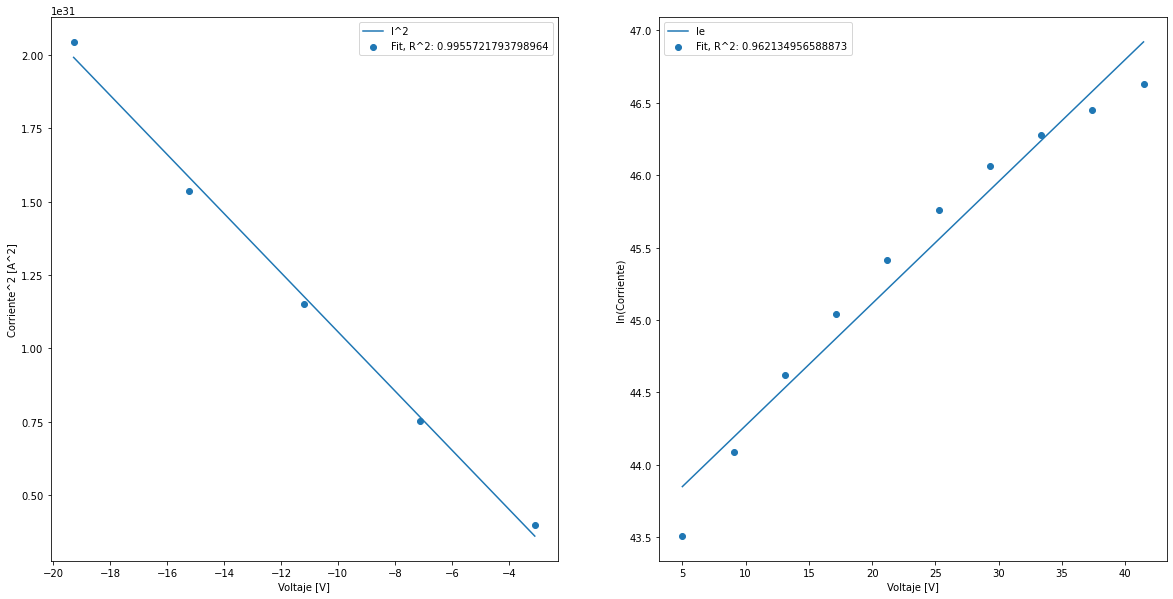

((<Quantity 11.87207025 eV>, <Quantity 0.01181571 eV>),
 (<Quantity 1.0035833e+15 1 / m3>, <Quantity 1.22413171e+21 1 / m3>),
 (<Quantity -0.49446881 V>, <Quantity 0.98654221 V>))

In [28]:
t_OML, ni_OML, Vs1_OML = OMLPlot(Voltaje,Corriente)
t_OML, ni_OML, Vs1_OML

### Análisis para los resultados obtenidos con OML

Se observa cómo ambos comportamientos presenta una buena linealidad. A este punto ya se conocen la temperatura eectrónica y la densidad iónica con OML, así como el voltaje temporal del plasma. Cuando se utiliza OML, las corrientes de saturación se pueden extraer de igual forma que con el modelo de Langmuir-Motley, pues para ambos casos se trabaja con una distribución maxwelliana de las partículas del plasma. Como se observa, la propuesta de utilizar la relación definitivamente no funciona, obteniendo densidades electrónicas muy por debajo de lo que se espera, mientras que el voltaje del plasma alcanza un valor que ni siquiera se encuentra en el rango de las mediciones, de forma que se debe buscar proceder con lo que presenta Langmuir.
De acuerdo con Chen, no es recomendable aplicar la derivada de $I_{e}(V_{p})$ para casos en los que el comportamiento es como el que se observó anteriormente, sino que debe aproximarse desde una observación bimaxwelliana.

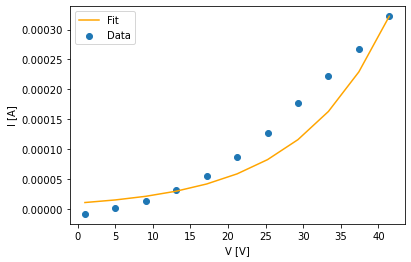

In [29]:
Pos_Values,_ = PositivoNegativo(Corriente,Voltaje)
Te = t_OML[0].value
Vp = voltaje_s[0].value
me = scipy.constants.physical_constants['electron mass'][0]
e_c = scipy.constants.physical_constants['elementary charge'][0]
Currents = probe_area.value*densidad_e[0].value*e_c*np.sqrt(e_c*Te/(2*np.pi*me))*np.exp((np.array(Pos_Values[0])-Vp)/Te)
plt.plot(Pos_Values[0][:np.where(Pos_Values[0]==Vp)[0][0]+1],Currents[:np.where(Pos_Values[0]==Vp)[0][0]+1],color='orange')
plt.scatter(Pos_Values[0][:np.where(Pos_Values[0]==Vp)[0][0]+1],Pos_Values[1][:np.where(Pos_Values[0]==Vp)[0][0]+1])
plt.xlabel('V [V]')
plt.ylabel('I [A]')
plt.legend(['Fit','Data'])
plt.show()

In [30]:
anderson(Currents[:np.where(Pos_Values[0]==Vp)[0][0]+1]-Pos_Values[1][:np.where(Pos_Values[0]==Vp)[0][0]+1],dist='norm').statistic,anderson(Currents[:np.where(Pos_Values[0]==Vp)[0][0]+1]-Pos_Values[1][:np.where(Pos_Values[0]==Vp)[0][0]+1],dist='norm').critical_values

(0.3144482893935887, array([0.498, 0.567, 0.68 , 0.793, 0.944]))

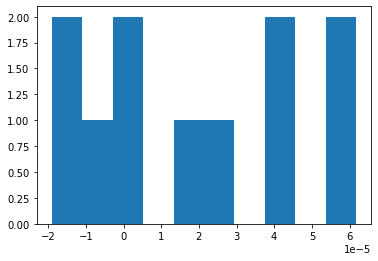

In [31]:
plt.hist(Pos_Values[1][:np.where(Pos_Values[0]==Vp)[0][0]+1]-Currents[:np.where(Pos_Values[0]==Vp)[0][0]+1])
plt.show()

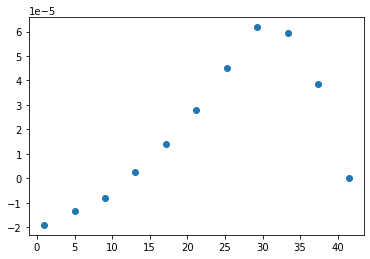

In [32]:
plt.scatter(Pos_Values[0][:np.where(Pos_Values[0]==Vp)[0][0]+1],Pos_Values[1][:np.where(Pos_Values[0]==Vp)[0][0]+1]-Currents[:np.where(Pos_Values[0]==Vp)[0][0]+1])
plt.show()

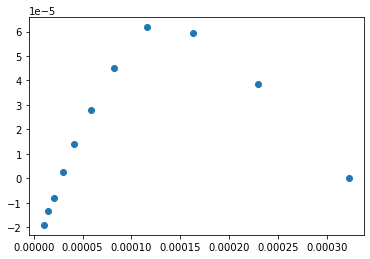

In [33]:
plt.scatter(Currents[:np.where(Pos_Values[0]==Vp)[0][0]+1],Pos_Values[1][:np.where(Pos_Values[0]==Vp)[0][0]+1]-Currents[:np.where(Pos_Values[0]==Vp)[0][0]+1])
plt.show()

Como se observa, aplicando el modelo con los datos obtenidos de aplicar el método de Langmuir-Motley para obtener el voltaje espacial y la densidad electrónica, corresponde con el punto en el que se desvían los datos medidos para la corriente de electrones, de forma que este método se puede integran en conjunto con OML, para terminar la caracterización del plasma. Sin embargo, para los casos en lo que esto no se cumpla, será necesario recurrir a una distribución Bimawelliana de los iones, según comenta Chen.

## Distribución Bimaxwelliana para la obtención del Potencial del plasma



# Teoría ABR

La solución expuesta en el paper de Allen deja la relación entre la corriente y el voltaje para una sonda cilíndrica como:

$$\frac{I_{i}^{2}}{8\pi^2r_{p}^2} = \left(\frac{n_{i,0}e}{\pi}\right)^2\left(\frac{-e}{M_{i}}\right)\sin^2{\left(\frac{n_{i}}{n_{i,0}}\pi\right)}V$$

Como se desea resolver para $n_{i}$, se pueden tomar casos para la relación $\frac{n_{i}}{n_{i,0}}$ que ayuden a simplificar la estimación de $n_{i}$, por ejemplo:

### $\sin{\left(\frac{n_{i}}{n_{i,0}}\pi\right)}\approx\frac{n_{i}}{n_{i,0}}\pi$

Para este caso, la expresión queda como:

$$\frac{I_{i}^{2}}{8\pi^2r_{p}^2} = \left(\frac{-e^2}{M_{i}}\right)n_{i}^2V$$

### $\frac{n_{i}}{n_{i,0}}\pi\approx\alpha\pi$

De aquí, se pueden extraer dos casos:

#### $\alpha\in\left\{\frac{1}{2},\frac{3}{2},\frac{5}{2},...\right\}$

Para cuales quiera $\alpha$ de esta forma, la expresión queda como:

$$\frac{I_{i}^{2}}{8\pi^2r_{p}^2} = -e^3\left(\frac{n_{i,0}^2}{\pi^2 M_{i}}\right)V$$

Se puede entonces resolver para $n_{i,0}$ y luego obtener el valor de $n_{i}$, pues viene dado por $n_{i}=\alpha n_{i,0}$.

#### $\alpha\in\left\{1,2,3,...\right\}$

Para todos estos casos $\frac{I_{i}^{2}}{4\pi^2r_{p}^2}=0$, por lo que se espera que esto no sea real, pues $n_{i}\rightarrow\infty$.

In [34]:
def ABRPlot(Voltajes,Corrientes,alpha):
    Pos_Values,Neg_Values = PositivoNegativo(Corrientes,Voltajes)
    probe_radius = 1*10**(-3)/2
    Ap = (3.5*10**(-3)*np.pi*1*10**(-3)+np.pi*(1*10**(-3))**2*0.25)
    
    I2 = (Neg_Values[1])**2/(8*np.pi**2*probe_radius**2)
    lnI = np.log((Pos_Values[1][np.where(Pos_Values[1]>0)]-corriente_i[0].value)/(e_c*Ap))
    
    fig, ((ax3,ax4)) = plt.subplots(1,2,figsize = (20, 10))
    
    result3 = scipy.stats.linregress(Neg_Values[0],I2)
    Volt_Neg=Neg_Values[0].copy()
    ax3.set_xlabel('Voltaje [V]')
    ax3.set_ylabel('Corriente^2 [A^2]')
    count3 = 0
    while result3.rvalue**2<1:
        index = np.where(np.array(I2) == np.max(np.array(I2)))
        I2=np.delete(I2,index)
        Volt_Neg=np.delete(Volt_Neg,index)
        result3 = scipy.stats.linregress(Volt_Neg,I2)
        count3 = count3+1
        if count3>0.65*len(Neg_Values[0]):
            break
    fitI2 = result3.slope*Volt_Neg+result3.intercept
    ax3.scatter(Volt_Neg,I2)
    ax3.plot(Volt_Neg,fitI2)
    ax3.legend(['I^2','Fit, R^2: '+str(result3.rvalue**2)])
    
    result4 = scipy.stats.linregress(Pos_Values[0][np.where(Pos_Values[1]>0)],lnI)
    Volt_Pos = Pos_Values[0][np.where(Pos_Values[1]>0)]
    ax4.set_xlabel('Voltaje [V]')
    ax4.set_ylabel('ln(Corriente)')
    count4 = 0
    while result4.rvalue**2<1:
        index = np.where(lnI == np.max(lnI))
        Volt_Pos=np.delete(Volt_Pos,index)
        lnI=np.delete(lnI,index)
        result4 = scipy.stats.linregress(Volt_Pos,lnI)
        count4 = count4+1
        if count4>0.65*len(Pos_Values[0])or Volt_Pos[-1]<=Pos_Values[0][np.where(dIdV==np.max(dIdV))]:
            break
    fitlnI = result4.slope*Volt_Pos+result4.intercept
    ax4.scatter(Volt_Pos,lnI)
    ax4.plot(Volt_Pos,fitlnI)
    ax4.legend(['Ie','Fit, R^2: '+str(result4.rvalue**2)])
    
    temperatura = 1/result4.slope
    n_i0 = np.sqrt(-result3.slope*Mi*np.pi**2/(e_c**3*np.sin(alpha*np.pi)**2))
    n_i=alpha*n_i0
    plt.show()
    return (temperatura*u.eV,2*result4.stderr/result4.slope**2*u.eV), (n_i*1/u.m**3,2*result3.stderr*alpha/(2*np.sqrt(n_i0))*1/u.m**3)

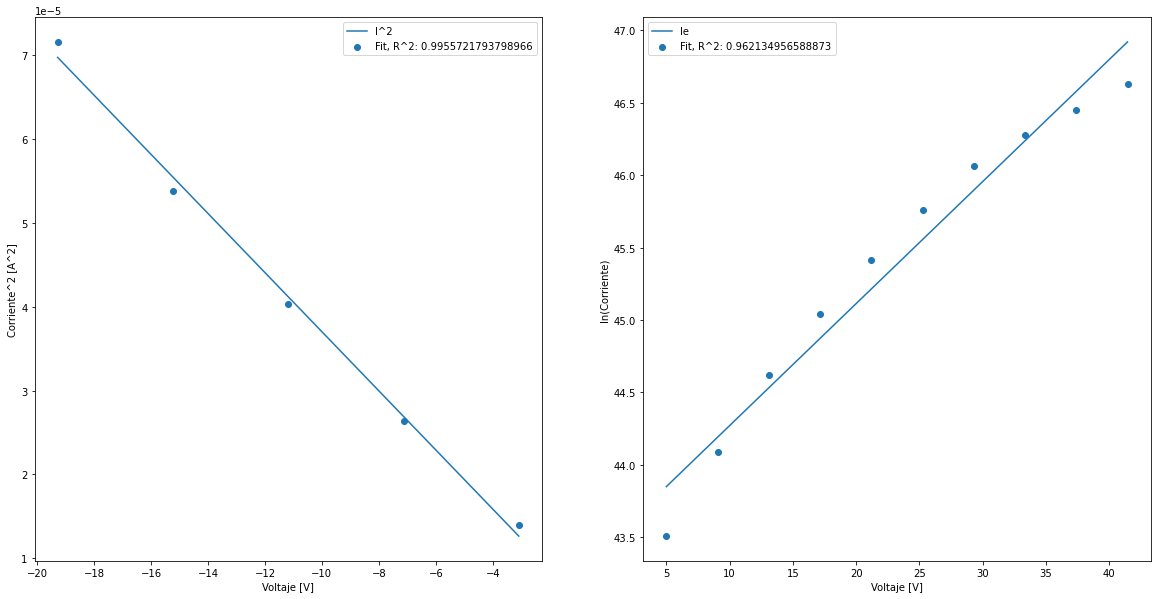

((<Quantity 11.87207025 eV>, <Quantity 1.6653775 eV>),
 (<Quantity 9.40859347e+12 1 / m3>, <Quantity 1.75084906e-13 1 / m3>))

In [35]:
t_ABR, ni_ABR=ABRPlot(Voltaje,Corriente,2.5)
t_ABR, ni_ABR

### Análisis para los resultados obtenidos con ABR

Se observa cómo ambos comportamientos presenta una buena linealidad. Para poder escoger cuál teoría utilizar, será necesario determinar mejor los límites de tolerancia entre los que se encuentra la densidad iónica, pues sólo de esa forma se podrá escoger entre OML y ABR. Se observa que ABR resenta una incertidumbre mucho menor, de forma que promete ser una mejor teoría a aplicar. Un factor importante es $\alpha$, que se debe poder asegurar que está bien definido para poder asegurar que la estimación es correcta.

# Teoría BRL

Esta teoría se conforma del paper de Bernstein y Rabinowitz y posterirormente la tesis de Laframboise y busca combinar los desarrollos de Langmuir-Mottley y ABR para crear una teoría que toma en cuenta la órbita y la capa en torno al electrodo.

# Implementación de Distribuciones Distintas a la Maxwelliana

Una propuesta adicional al proceso de identificación de la forma en la que se ajustan las teorías al análisis de las corrientes medidas por la sonda simple. Siguiendo la propuesta de Darian, Marholm, Mortensen y Miloch, se implementarán funciones de distribución Kappa, Cairn y Kappa-Cairn. Se iniciará haciendo la aplicación de esta última para sondas cilíndricas pues se presenta de forma más explícita en el artículo.

## Kappa-Cairn

In [36]:
from scipy.special import gamma

In [37]:
kappa=15
alpha=0.5
D=3

In [38]:
def KappaCairnConstant(T):
    return gamma(kappa+1)/(gamma(kappa+(2-D)/2)*(2*np.pi*(T*e_c)/(me)*(kappa-D/2))**(D/2)*(1+D*(D+2)*alpha*(kappa-D/2)/(kappa-(D+2)/2)))

In [39]:
def KappaCairnDistribution(v,T):
    return KappaCairnConstant(T)*(1+alpha*v**4/((T*e_c)/(me))**2)*(1+v**2/(2*(kappa-D/2)*(T*e_c)/(me)))**(-kappa-1)

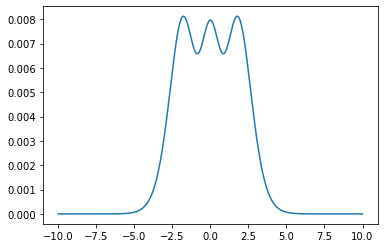

In [40]:
plt.plot(np.arange(-10,10,0.001),KappaCairnDistribution(np.arange(-10,10,0.001),me/e_c))
plt.show()

In [41]:
from scipy.optimize import curve_fit
from scipy.special import hyp2f1

In [42]:
C=(kappa-1/2)*np.sqrt(kappa-3/2)/(kappa-1)
D=(1+3*alpha*(kappa-3/2)/(kappa-1/2))/(1+15*alpha*(kappa-3/2)/(kappa-5/2))
E=4*alpha*kappa*(kappa-1)/((kappa-1/2)*(kappa-3/2)+3*alpha*(kappa-3/2)**2)

In [43]:
def CorrienteCapaGruesa(Voltaje,I,m):
    return (2/np.sqrt(np.pi))*I*C*D*(np.abs(Voltaje*m)/(kappa-3/2))**(1-kappa)*(np.abs(Voltaje*m)**2*E*(kappa-1)/(kappa-3)*hyp2f1(kappa-3,kappa+1/2,kappa-2,1-(kappa-3/2)/np.abs(Voltaje*m)))+np.abs(Voltaje*m)*E*(((kappa-3/2)-2*(kappa-1)*np.abs(Voltaje*m))/(kappa-2))*hyp2f1(kappa-2,kappa+1/2,kappa-1,1-(kappa-3/2)/np.abs(Voltaje*m))+(1+E*np.abs(Voltaje*m)*(np.abs(Voltaje*m)-(kappa-3/2)/(kappa-1)))*hyp2f1(kappa-1,kappa+1/2,kappa,1-(kappa-3/2)/np.abs(Voltaje*m))

In [44]:
coefsCapaGruesa,_=curve_fit(CorrienteCapaGruesa,Pos_Values[0],Pos_Values[1],p0=np.array([0.0003,1/10]))

In [45]:
m=coefsCapaGruesa[1]
I=coefsCapaGruesa[0]

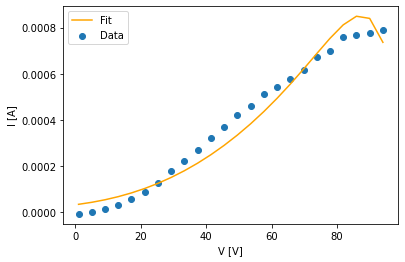

In [46]:
plt.scatter(Pos_Values[0],Pos_Values[1])
plt.plot(Pos_Values[0],CorrienteCapaGruesa(Pos_Values[0],coefsCapaGruesa[0],coefsCapaGruesa[1]),color='orange')
plt.legend(['Fit','Data'])
plt.xlabel('V [V]')
plt.ylabel('I [A]')
plt.show()

In [47]:
def AlphaKappa(Voltaje,kappa,alpha):
    return (2/np.sqrt(np.pi))*I*C*D*(np.abs(Voltaje*m)/(kappa-3/2))**(1-kappa)*(np.abs(Voltaje*m)**2*E*(kappa-1)/(kappa-3)*hyp2f1(kappa-3,kappa+1/2,kappa-2,1-(kappa-3/2)/np.abs(Voltaje*m)))+np.abs(Voltaje*m)*E*(((kappa-3/2)-2*(kappa-1)*np.abs(Voltaje*m))/(kappa-2))*hyp2f1(kappa-2,kappa+1/2,kappa-1,1-(kappa-3/2)/np.abs(Voltaje*m))+(1+E*np.abs(Voltaje*m)*(np.abs(Voltaje*m)-(kappa-3/2)/(kappa-1)))*hyp2f1(kappa-1,kappa+1/2,kappa,1-(kappa-3/2)/np.abs(Voltaje*m))

In [48]:
N=100
p=0
while p<N:
    coefsAK,_=curve_fit(AlphaKappa,Pos_Values[0],Pos_Values[1],p0=np.array([kappa,alpha]))
    alpha=coefsAK[1]
    kappa=coefsAK[0]
    coefsCapaGruesa,_=curve_fit(CorrienteCapaGruesa,Pos_Values[0],Pos_Values[1],p0=np.array([m,I]))
    m=coefsCapaGruesa[1]
    I=coefsCapaGruesa[0]
    p+=1

In [49]:
alpha,kappa,m,I

(0.5, 16.497487154050397, 0.03623048349115869, 8.022679364253999e-05)

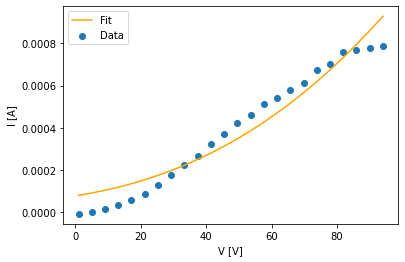

In [50]:
plt.scatter(Pos_Values[0],Pos_Values[1])
plt.plot(Pos_Values[0],CorrienteCapaGruesa(Pos_Values[0],I,m),color='orange')
plt.legend(['Fit','Data'])
plt.xlabel('V [V]')
plt.ylabel('I [A]')
plt.show()

In [51]:
anderson(Pos_Values[1]-CorrienteCapaGruesa(Pos_Values[0],I,m),dist='norm').statistic,anderson(Pos_Values[1]-CorrienteCapaGruesa(Pos_Values[0],I,m),dist='norm').critical_values

(0.8733157114244179, array([0.513, 0.584, 0.701, 0.817, 0.972]))

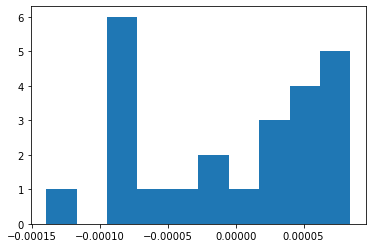

In [52]:
plt.hist(Pos_Values[1]-CorrienteCapaGruesa(Pos_Values[0],I,m))
plt.show()

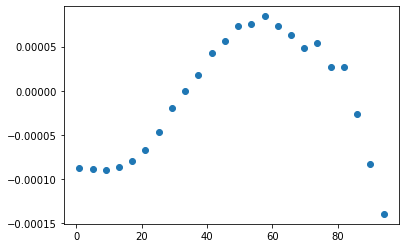

In [53]:
plt.scatter(Pos_Values[0],Pos_Values[1]-CorrienteCapaGruesa(Pos_Values[0],I,m))
plt.show()

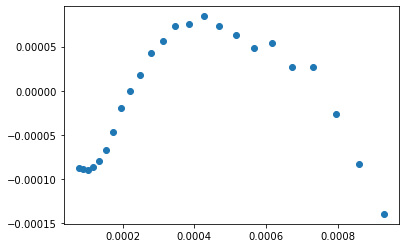

In [54]:
plt.scatter(CorrienteCapaGruesa(Pos_Values[0],I,m),Pos_Values[1]-CorrienteCapaGruesa(Pos_Values[0],I,m))
plt.show()

## Kappa

In [55]:
kappak=10

In [56]:
def CorrienteKappa(Voltaje,Ik,mk):
    return (2/np.sqrt(np.pi))*Ik*C*(np.abs(Voltaje*mk)/(kappak-3/2))**(1-kappak)*hyp2f1(kappak-1,kappak+1/2,kappak,1-(kappak-3/2)/np.abs(Voltaje*mk))

In [57]:
coefsKappa,_=curve_fit(CorrienteKappa,Pos_Values[0],Pos_Values[1])

In [58]:
Ik=coefsKappa[0]
mk=coefsKappa[1]

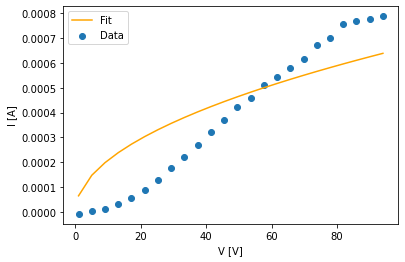

In [59]:
plt.scatter(Pos_Values[0],Pos_Values[1])
plt.plot(Pos_Values[0],CorrienteKappa(Pos_Values[0],Ik,mk),color='orange')
plt.legend(['Fit','Data'])
plt.xlabel('V [V]')
plt.ylabel('I [A]')
plt.show()

In [60]:
def Kappa(Voltaje,kappak):
    return (2/np.sqrt(np.pi))*Ik*C*(np.abs(Voltaje*mk)/(kappak-3/2))**(1-kappak)*hyp2f1(kappak-1,kappak+1/2,kappak,1-(kappak-3/2)/np.abs(Voltaje*mk))

In [61]:
N=100
p=0
while p<N:
    coefsK,_=curve_fit(Kappa,Pos_Values[0],Pos_Values[1],p0=kappak)
    kappak=coefsK[0]
    coefsKappa,_=curve_fit(CorrienteKappa,Pos_Values[0],Pos_Values[1],p0=np.array([Ik,mk]))
    mk=coefsKappa[1]
    Ik=coefsKappa[0]
    p+=1

In [62]:
kappak,mk,Ik

(10.0, -414.96684543577413, 2.317544824632421e-06)

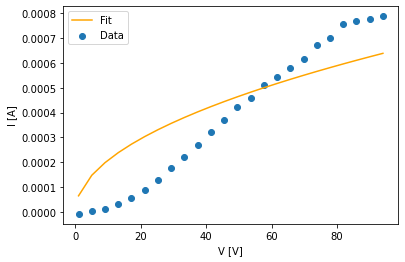

In [63]:
plt.scatter(Pos_Values[0],Pos_Values[1])
plt.plot(Pos_Values[0],CorrienteKappa(Pos_Values[0],Ik,mk),color='orange')
plt.legend(['Fit','Data'])
plt.xlabel('V [V]')
plt.ylabel('I [A]')
plt.show()

In [64]:
anderson(Pos_Values[1]-CorrienteKappa(Pos_Values[0],Ik,mk),dist='norm').statistic,anderson(Pos_Values[1]-CorrienteKappa(Pos_Values[0],Ik,mk),dist='norm').critical_values

(0.651977174609776, array([0.513, 0.584, 0.701, 0.817, 0.972]))

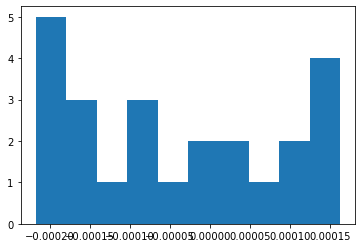

In [65]:
plt.hist(Pos_Values[1]-CorrienteKappa(Pos_Values[0],Ik,mk))
plt.show()

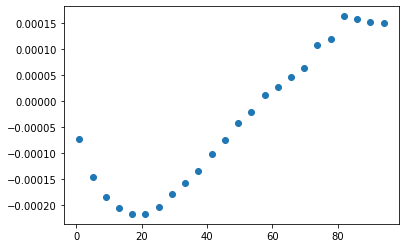

In [66]:
plt.scatter(Pos_Values[0],Pos_Values[1]-CorrienteKappa(Pos_Values[0],Ik,mk))
plt.show()

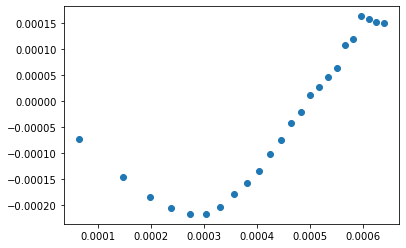

In [67]:
plt.scatter(CorrienteKappa(Pos_Values[0],Ik,mk),Pos_Values[1]-CorrienteKappa(Pos_Values[0],Ik,mk))
plt.show()

## Cairn

In [68]:
from scipy.special import erf
from scipy.special import erfc

In [69]:
alphac=alpha

In [70]:
def CorrienteCairn(Voltaje,Ic,mc):
    return Ic*(1+24*alphac)/(1+15*alphac)*((2/np.sqrt(np.pi))*(1-2*alphac*np.abs(Voltaje*mc)/(1+24*alphac))*np.sqrt(np.abs(Voltaje*mc))+np.exp(np.abs(Voltaje*mc))*(1+4*alphac*np.abs(Voltaje*mc)*(np.abs(Voltaje*alphac)-4)/(1+24*alphac))*erfc(np.sqrt(np.abs(Voltaje*mc))))

In [71]:
coefsCairn,_=curve_fit(CorrienteCairn,Pos_Values[0],Pos_Values[1])

In [72]:
Ic=coefsCairn[0]
mc=coefsCairn[1]

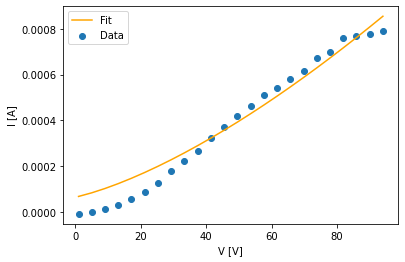

In [73]:
plt.scatter(Pos_Values[0],Pos_Values[1])
plt.plot(Pos_Values[0],CorrienteCairn(Pos_Values[0],Ic,mc),color='orange')
plt.legend(['Fit','Data'])
plt.xlabel('V [V]')
plt.ylabel('I [A]')
plt.show()

In [74]:
def Alpha(Voltaje,alphac):
    return Ic*(1+24*alphac)/(1+15*alphac)*((2/np.sqrt(np.pi))*(1-2*alphac*np.abs(Voltaje*mc)/(1+24*alphac))*np.sqrt(np.abs(Voltaje*mc))+np.exp(np.abs(Voltaje*mc))*(1+4*alphac*np.abs(Voltaje*mc)*(np.abs(Voltaje*alphac)-4)/(1+24*alphac))*erfc(np.sqrt(np.abs(Voltaje*mc))))

In [75]:
N=100
p=0
while p<N:
    coefsA,_=curve_fit(Alpha,Pos_Values[0],Pos_Values[1],p0=alphac)
    alphac=coefsA[0]
    coefsCairn,_=curve_fit(CorrienteCairn,Pos_Values[0],Pos_Values[1],p0=np.array([Ic,mc]))
    mc=coefsCairn[1]
    Ic=coefsCairn[0]
    p+=1

In [76]:
alphac,mc,Ic

(0.7233195476459635, 0.22089733306265583, 2.548100147139527e-05)

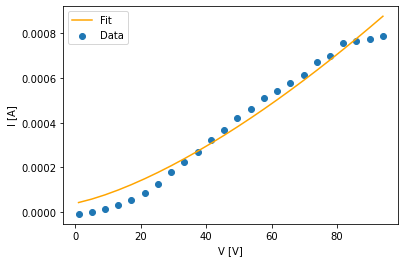

In [77]:
plt.scatter(Pos_Values[0],Pos_Values[1])
plt.plot(Pos_Values[0],CorrienteCairn(Pos_Values[0],Ic,mc),color='orange')
plt.legend(['Fit','Data'])
plt.xlabel('V [V]')
plt.ylabel('I [A]')
plt.show()

In [78]:
anderson(Pos_Values[1]-CorrienteCairn(Pos_Values[0],Ic,mc),dist='norm').statistic,anderson(Pos_Values[1]-CorrienteCairn(Pos_Values[0],Ic,mc),dist='norm').critical_values

(1.0382424966882233, array([0.513, 0.584, 0.701, 0.817, 0.972]))

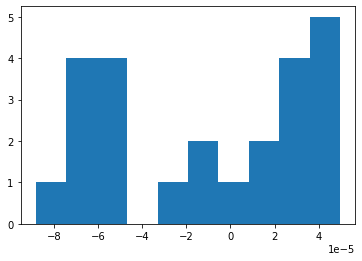

In [79]:
plt.hist(Pos_Values[1]-CorrienteCairn(Pos_Values[0],Ic,mc))
plt.show()

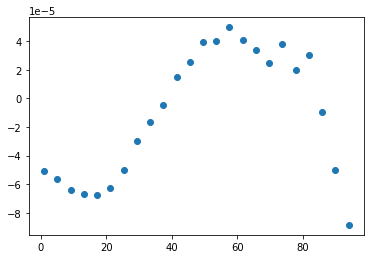

In [80]:
plt.scatter(Pos_Values[0],Pos_Values[1]-CorrienteCairn(Pos_Values[0],Ic,mc))
plt.show()

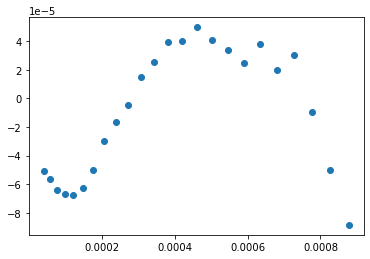

In [81]:
plt.scatter(CorrienteCairn(Pos_Values[0],Ic,mc),Pos_Values[1]-CorrienteCairn(Pos_Values[0],Ic,mc))
plt.show()

## Maxwellian

In [82]:
def CorrienteMaxwellian(Voltaje,Im,mm,Vm):
    return Im*((2/np.sqrt(np.pi))*np.sqrt(np.abs(mm*(Voltaje-Vm)))+np.exp(np.abs((Voltaje-Vm)*mm))*erfc(np.sqrt(np.abs(mm*(Voltaje-Vm)))))

In [83]:
coefsM,_=curve_fit(CorrienteMaxwellian,Pos_Values[0],Pos_Values[1])

In [84]:
Im=coefsM[0]
mm=coefsM[1]
Vm=coefsM[2]

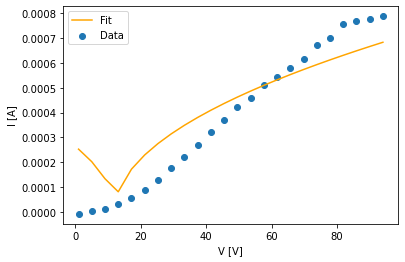

In [85]:
plt.scatter(Pos_Values[0],Pos_Values[1])
plt.plot(Pos_Values[0],CorrienteMaxwellian(Pos_Values[0],Im,mm,Vm),color='orange')
plt.legend(['Fit','Data'])
plt.xlabel('V [V]')
plt.ylabel('I [A]')
plt.show()

In [86]:
anderson(Pos_Values[1]-CorrienteMaxwellian(Pos_Values[0],Im,mm,Vm),dist='norm').statistic,anderson(Pos_Values[1]-CorrienteMaxwellian(Pos_Values[0],Im,mm,Vm),dist='norm').critical_values

(0.3810571199991486, array([0.513, 0.584, 0.701, 0.817, 0.972]))

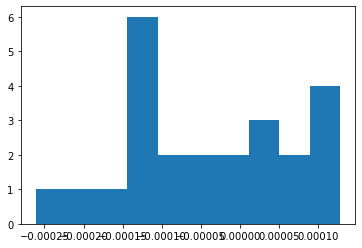

In [87]:
plt.hist(Pos_Values[1]-CorrienteMaxwellian(Pos_Values[0],Im,mm,Vm))
plt.show()

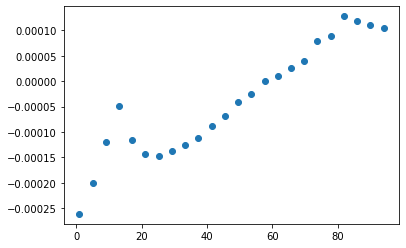

In [88]:
plt.scatter(Pos_Values[0],Pos_Values[1]-CorrienteMaxwellian(Pos_Values[0],Im,mm,Vm))
plt.show()

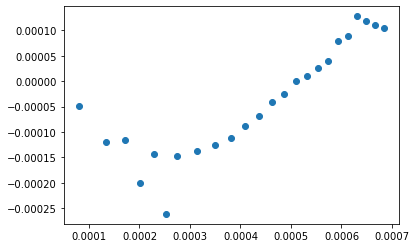

In [89]:
plt.scatter(CorrienteMaxwellian(Pos_Values[0],Im,mm,Vm),Pos_Values[1]-CorrienteMaxwellian(Pos_Values[0],Im,mm,Vm))
plt.show()